# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder,
                                   LabelEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             plot_roc_curve,
                             roc_auc_score,
                             f1_score,
                             confusion_matrix)
from sklearn.model_selection import train_test_split


from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
       
    return np.sin(2*w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * grad_f(curr_w) #  YOUR CODE. Не забудьте про lr!

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

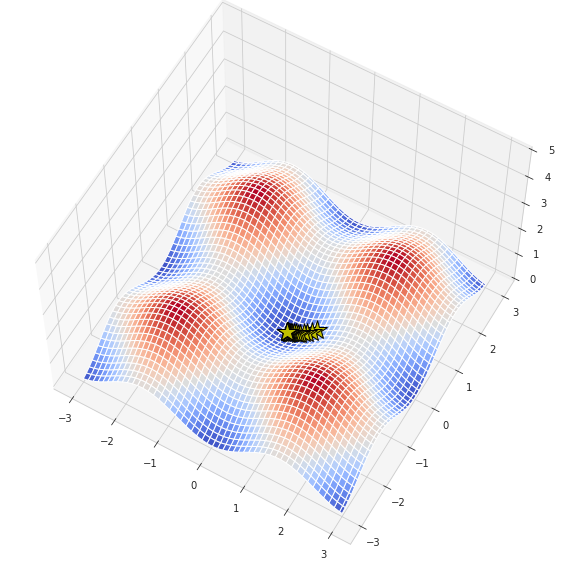

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

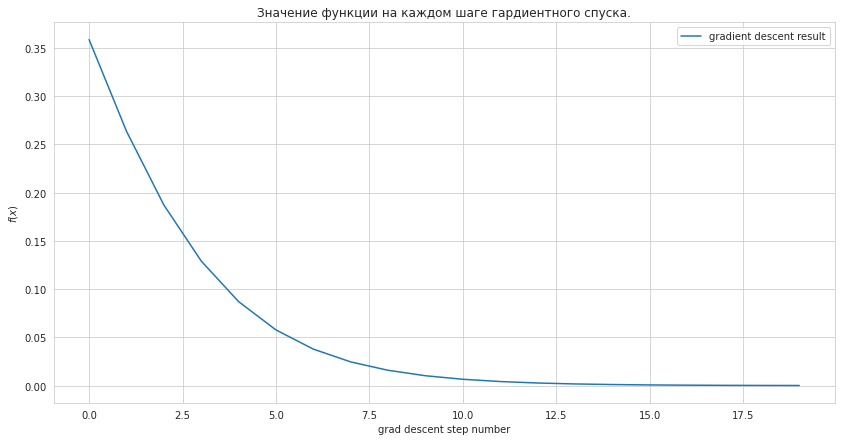

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return np.sum((y_true - y_pred)**2) / y_true.shape[0]
    


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    X_t = X.transpose()
    
    return 2 * np.matmul(X_t, y_pred - y_true) / y_true.shape[0]


class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        else:
            X_new = X
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        return np.matmul(X_test, self.W)
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

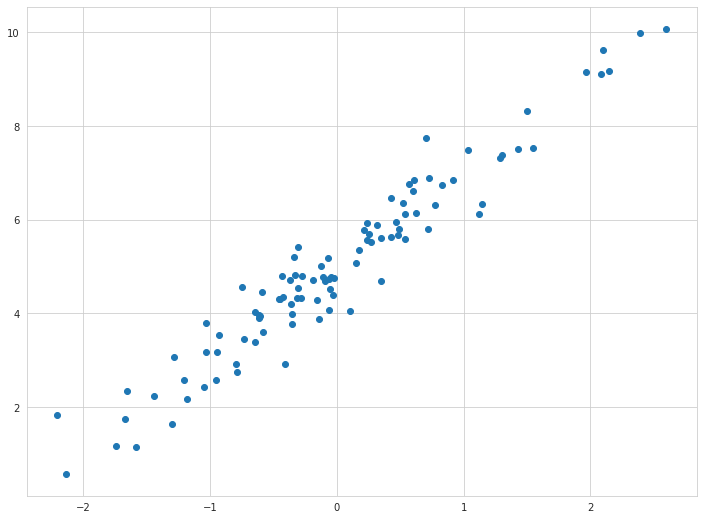

In [15]:
plt.scatter(X, y);

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

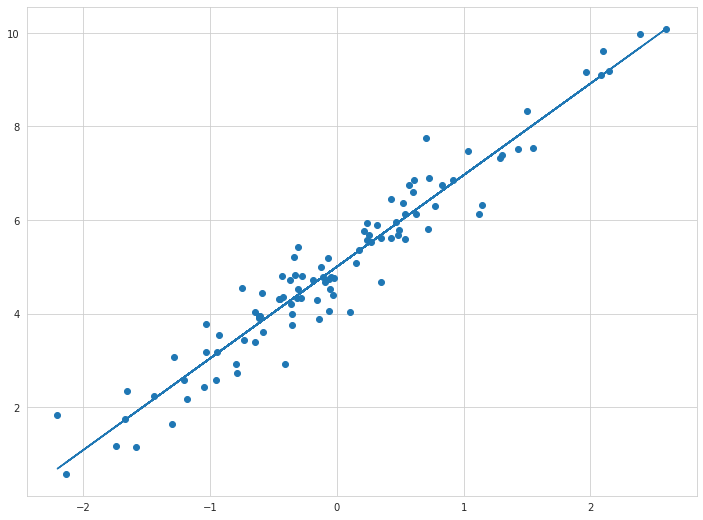

In [18]:
plt.scatter(X, y)
plt.plot(X, custom_lin_reg.predict(X));

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [21]:
linear_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("linear", LinearRegression(n_jobs=-1))
])

In [22]:
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear', LinearRegression(n_jobs=-1))])

In [23]:
y_pred = linear_pipeline.predict(X_test)

In [24]:
r2_score(y_test, y_pred)

0.5961285884453013

In [25]:
linear_pipeline['linear'].coef_

array([ 0.82824232,  0.12153239, -0.26117647,  0.30524043, -0.00653505,
       -0.03964943, -0.888757  , -0.85848682])

In [26]:
print(list(zip(feature_names, linear_pipeline['linear'].coef_)))

[('MedInc', 0.8282423184712363), ('HouseAge', 0.12153239080188641), ('AveRooms', -0.261176468435915), ('AveBedrms', 0.30524042821649466), ('Population', -0.00653505027084326), ('AveOccup', -0.03964943167987536), ('Latitude', -0.8887569973701652), ('Longitude', -0.8584868209338539)]


Looks like MedInc(medical insurance?), Latitude & Longitude are the most important

In [27]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = feature_names
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X, i)
                          for i in range(len(feature_names))]
  
print(vif_data)

      feature         VIF
0      MedInc   11.511140
1    HouseAge    7.195917
2    AveRooms   45.993601
3   AveBedrms   43.590314
4  Population    2.935745
5    AveOccup    1.095243
6    Latitude  559.874071
7   Longitude  633.711654


Looks like AveRooms & AveBedrms are correlated and Latitude & Longitude are correlated(why?). Let's remove one of each pair.

In [28]:
feature_names = ['MedInc',
 'HouseAge',
 'AveRooms',
 'Population',
 'AveOccup',
 'Latitude']

In [29]:
X = X[:, [0, 1, 2, 4, 5, 6]]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [31]:
linear_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("linear", LinearRegression(n_jobs=-1))
])

In [32]:
linear_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear', LinearRegression(n_jobs=-1))])

In [33]:
y_pred = linear_pipeline.predict(X_test)

In [34]:
r2_score(y_test, y_pred)

0.5032390488773841

Metric became worse. 

In [35]:
print(list(zip(feature_names, linear_pipeline['linear'].coef_)))

[('MedInc', 0.8307425578883305), ('HouseAge', 0.22311384651981578), ('AveRooms', -0.044178308379521025), ('Population', 0.021129473598159323), ('AveOccup', -0.04830164149387926), ('Latitude', -0.09485354993306014)]


It's strange, but the impact of latitude became less.

:(

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [36]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1 / (1 + np.exp((-1) * output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [37]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    
    return -1 * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    X_t = X.transpose()
    
    return np.matmul(X_t, y_pred - y_true)


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [38]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        prediction = np.matmul(X_test, self.W)
        return sigmoid(prediction)
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [39]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

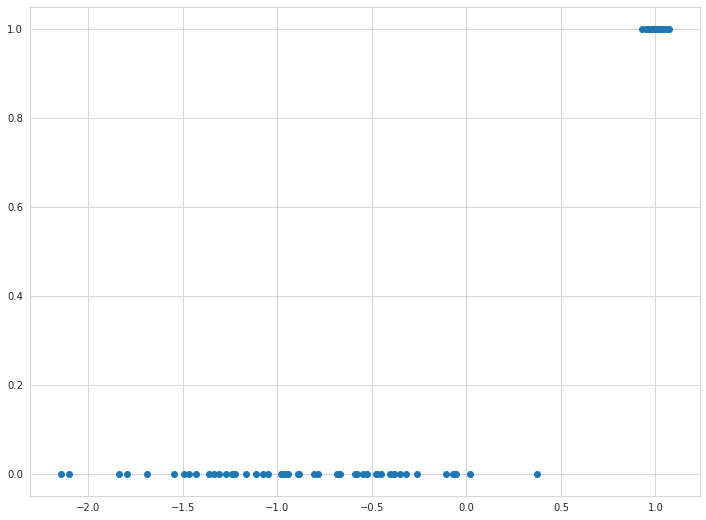

In [40]:
plt.scatter(X, y);

In [41]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

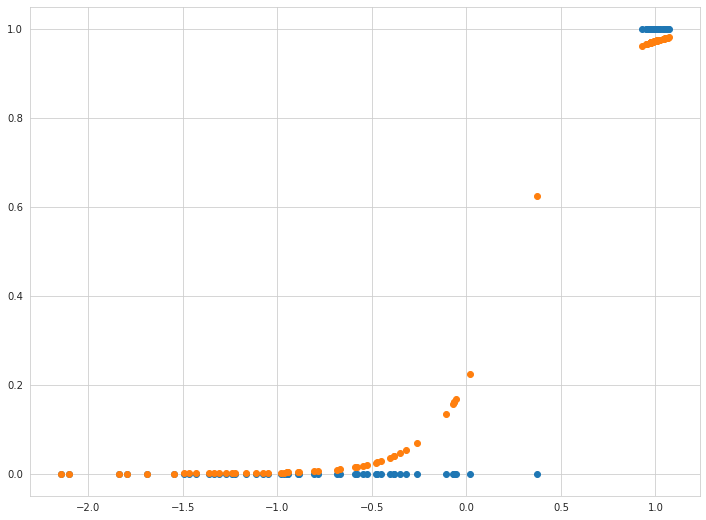

In [42]:
plt.scatter(X, y)
plt.scatter(X, y_pred);

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [43]:
roc_auc_score(y, y_pred)

1.0

Why?

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

In [44]:
pokemon = pd.read_csv("Data/Pokemon.csv")
pokemon.tail()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True
799,721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,True


In [45]:
pokemon.shape

(800, 13)

In [46]:
pokemon['Name'].unique().shape

(800,)

Each pokemon has its unique name, we don't need this variable.

In [47]:
pokemon['Type 1'].unique()

array(['Grass', 'Fire', 'Water', 'Bug', 'Normal', 'Poison', 'Electric',
       'Ground', 'Fairy', 'Fighting', 'Psychic', 'Rock', 'Ghost', 'Ice',
       'Dragon', 'Dark', 'Steel', 'Flying'], dtype=object)

In [48]:
pokemon['Type 2'].unique()

array(['Poison', nan, 'Flying', 'Dragon', 'Ground', 'Fairy', 'Grass',
       'Fighting', 'Psychic', 'Steel', 'Ice', 'Rock', 'Dark', 'Water',
       'Electric', 'Fire', 'Ghost', 'Bug', 'Normal'], dtype=object)

In [49]:
pokemon['Generation'].unique()

array([1, 2, 3, 4, 5, 6])

In [50]:
X = pokemon.drop(['#', 'Name', 'Legendary'], axis = 1)

In [51]:
y = pokemon['Legendary']

In [52]:
le = LabelEncoder()

In [53]:
y_trans = le.fit_transform(y)

In [55]:
len(y_trans)

800

In [56]:
sum(y_trans)

65

Ill balanced.

In [58]:
cat_cols = ['Type 1', 'Type 2']

In [59]:
num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed']

I'm not sure what to do with Generation

In [60]:
X[num_cols].describe()

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
count,800.00000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,435.10250,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,119.96304,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,180.00000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,330.00000,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,450.00000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,515.00000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,780.00000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [61]:
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X[num_cols]))

In [62]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = num_cols
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i)
                          for i in range(len(num_cols))]
  
print(vif_data)

   feature  VIF
0    Total  inf
1       HP  inf
2   Attack  inf
3  Defense  inf
4  Sp. Atk  inf
5  Sp. Def  inf
6    Speed  inf


/home/natalya/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


0_0

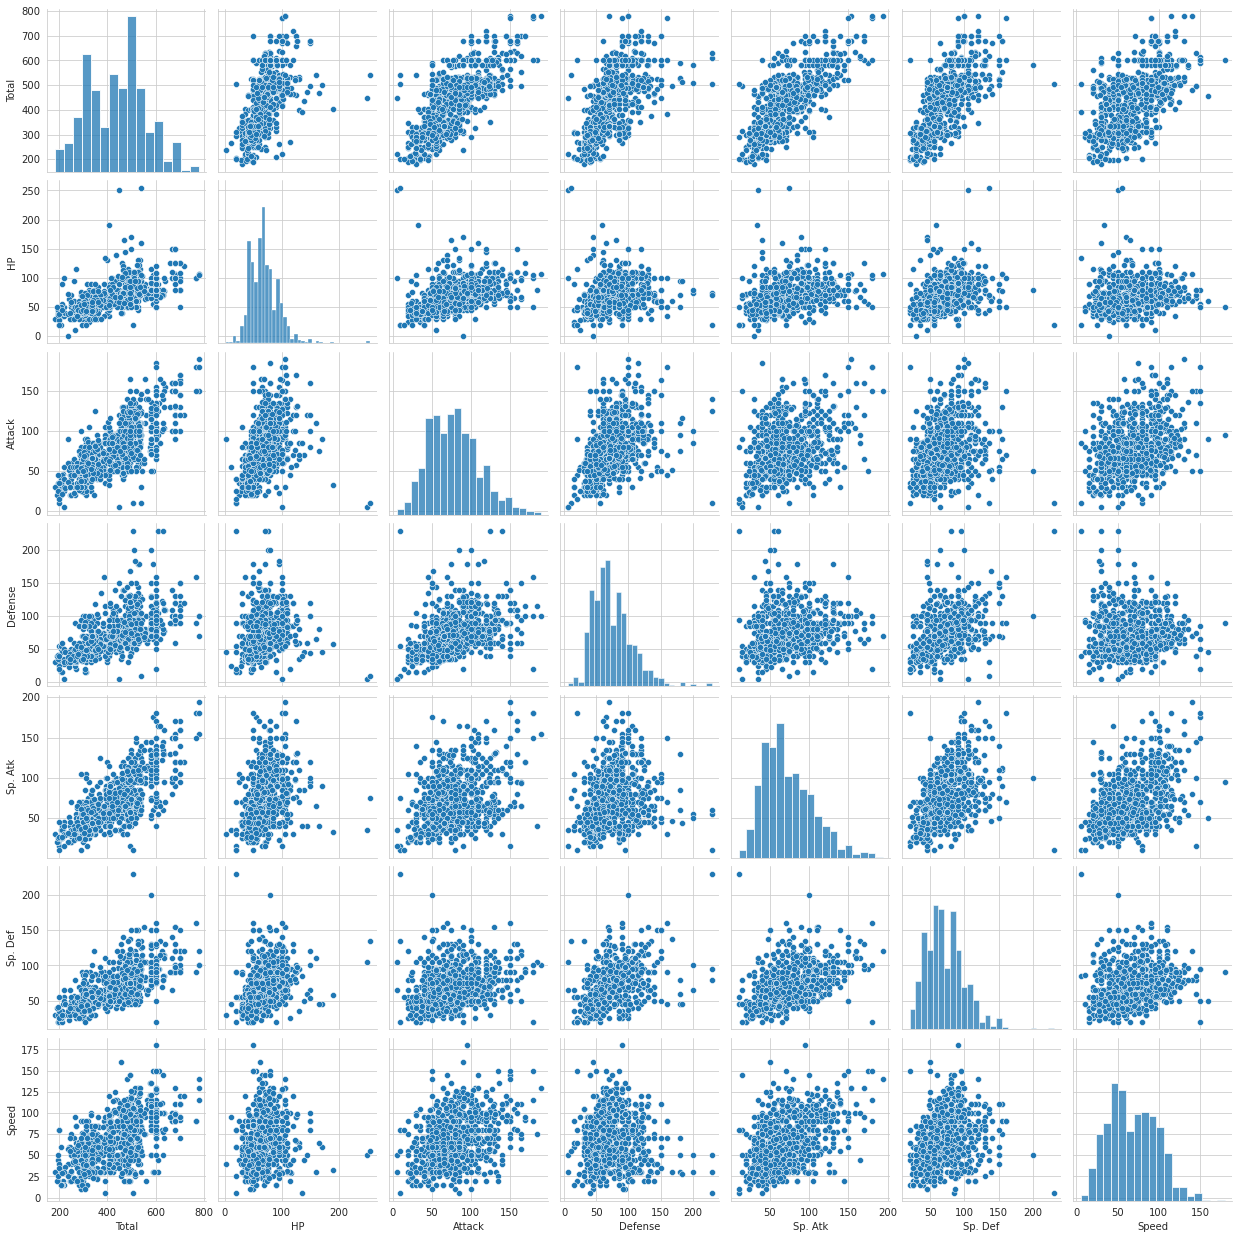

In [63]:
import seaborn as sns
sns.pairplot(X[num_cols])

Looks like 'Total' is correlated with all other variables.

<AxesSubplot:ylabel='Total'>

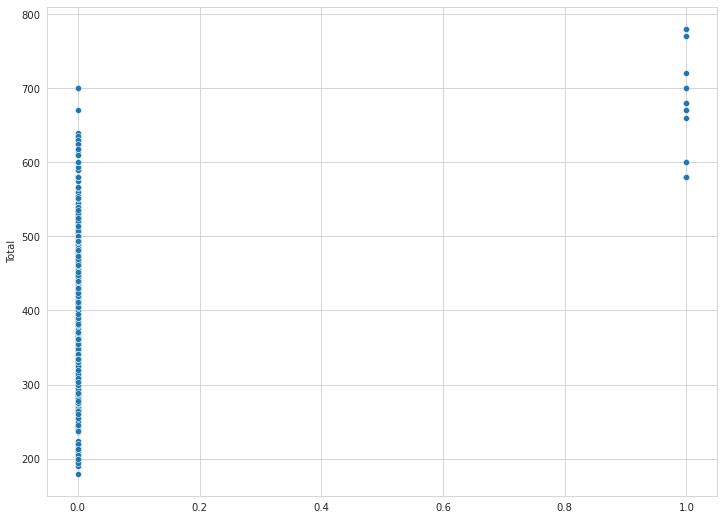

In [64]:
sns.scatterplot(x=y_trans, y=X['Total'])

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

## Whole dataset.

Разделите ваши данные на тестовую и тренировочную выборку.

In [65]:
cat_cols = ['Type 1', 'Type 2']
num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation']

In [66]:
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols)
])

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y_trans, test_size=0.2, random_state=SEED)

Обучите модель `LogisticRegression` из `sklearn`.

In [68]:
logreg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("logreg", LogisticRegression(random_state=SEED))
])

logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)

In [69]:
f1_score(y_test, y_pred)

0.6206896551724137

## Let's save only numerical variables

In [70]:
num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed', 'Generation']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X[num_cols], y_trans, test_size=0.2, random_state=SEED)

In [72]:
logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=SEED))
])

logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)

In [73]:
f1_score(y_test, y_pred)

0.7142857142857143

Became a bit better.

## Remove Generation

In [74]:
num_cols = ['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk',
       'Sp. Def', 'Speed']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X[num_cols], y_trans, test_size=0.2, random_state=SEED)

In [76]:
logreg_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=SEED))
])

logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)

In [77]:
f1_score(y_test, y_pred)

0.5806451612903226

Became worse.

## Remove Total - it correlates with many other variables

In [78]:
num_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk',
        'Sp. Def', 'Speed', 'Generation']

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X[num_cols], y_trans, test_size=0.2, random_state=SEED)

In [80]:
ticRegression = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=SEED))
])

logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)

In [81]:
f1_score(y_test, y_pred)

0.7142857142857143

The result didn't change. Looks like this variable doesn't matter. Or?..

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

### Confusion matrix

In [82]:
confusion_matrix(y_test, y_pred)

array([[142,   0],
       [  8,  10]])

### ROC, ROC AUC

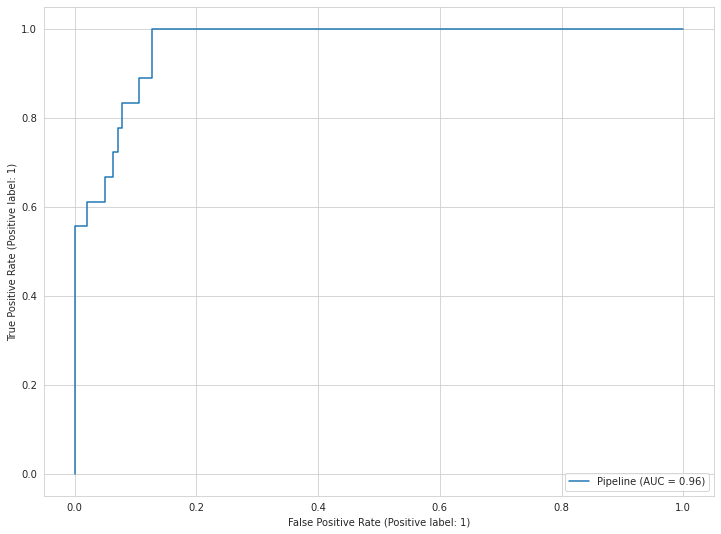

In [85]:
plot_roc_curve(logreg_pipeline, X_test, y_test);

In [86]:
y_proba = logreg_pipeline.predict_proba(X_test)[:, 1]

In [87]:
roc_auc_score(y_test, y_proba)

0.9643974960876369

### Most important variables

F1 score became better after removing categorical variables, it didn't change after removing 'Total' variable (was correlated with many other variables).

In [88]:
print(list(zip(num_cols, logreg_pipeline['logreg'].coef_[0])))

[('HP', 0.5580814159712478), ('Attack', 0.6222991616249205), ('Defense', 1.064472366507119), ('Sp. Atk', 1.1580213276210223), ('Sp. Def', 1.1916231340836096), ('Speed', 1.439910909664735), ('Generation', 0.8692535383855209)]


### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Уже несколько лет это АИГЕЛ. Некоторые знают только их одну песню из тиктока, тем самым незаслужено недооценивая эту группу...

Узнала я про них, когда сидела одна на вокзале, грустила, что в своей долгой поездке буду вдалеке от любимого человека, листала новости и увидела пост медузы о новом альбоме этой группы. Когда я послушала первые песни, мне показалось это чем-то необычным и очень крутым, до сих пор так кажется

https://www.youtube.com/watch?v=6vkYvZpTHng

https://www.youtube.com/watch?v=tNPLXGDBSCg




## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**
Было интересно, наверное, не слишком сложно.